#Project 3.1

In [ ]:
from collections import Counter, defaultdict
from typing import List, Dict, Literal, Union

import os, re, random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from datasets import load_dataset, Dataset, ClassLabel
from collections import Counter
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

import warnings

warnings.filterwarnings("ignore")

CACHE_DIR = "./cache"

##Dataset

In [ ]:
# Load the dataset from the specified cache directory
ds = load_dataset("UniverseTBD/arxiv-abstracts-large", cache_dir=CACHE_DIR)
ds

README.md:   0%|          | 0.00/810 [00:00<?, ?B/s]

arxiv-metadata-oai-snapshot.json:   0%|          | 0.00/3.82G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2292057 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 2292057
    })
})

In [ ]:
ds = ds['train']
df = ds.to_pandas()

In [ ]:
# In thông tin tổng quan
print(ds.info)  # Hiển thị metadata như số lượng hàng, cột, và mô tả dataset

# Xem danh sách các trường (features)
print(ds.features)  # Kết quả: Dict với các trường như 'id': Value(dtype='string'), 'authors': Value(dtype='string'), v.v.

# Xem số lượng hàng
print(f"Số lượng hàng: {len(ds)}")

# Xem 5 hàng đầu tiên để có cái nhìn sơ bộ
print(ds.to_pandas().head(5))

# Tổng quan dataset
print(ds.to_pandas().info())

DatasetInfo(description='', citation='', homepage='', license='', features={'id': Value('string'), 'submitter': Value('string'), 'authors': Value('string'), 'title': Value('string'), 'comments': Value('string'), 'journal-ref': Value('string'), 'doi': Value('string'), 'report-no': Value('string'), 'categories': Value('string'), 'license': Value('string'), 'abstract': Value('string'), 'versions': List({'version': Value('string'), 'created': Value('string')}), 'update_date': Value('timestamp[s]'), 'authors_parsed': List(List(Value('string')))}, post_processed=None, supervised_keys=None, builder_name='json', dataset_name='arxiv-abstracts-large', config_name='default', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=3408503397, num_examples=2292057, shard_lengths=[364397, 340033, 326823, 311263, 302044, 305766, 341731], dataset_name='arxiv-abstracts-large')}, download_checksums={'hf://datasets/UniverseTBD/arxiv-abstracts-large@6020a62078a73d7ca02b86a4a775af7caba42d5e/arxiv

In [ ]:
# Define core fields that must be non-null
core_fields = ['id', 'authors', 'title', 'categories', 'abstract', 'versions', 'update_date', 'authors_parsed']

# Drop rows only if core fields have nulls
df_clean = df.dropna(subset=core_fields)
print(f"Số hàng sau khi loại bỏ null ở core fields: {len(df_clean)}")

# Extract main_category: take the first part before '.' from 'categories'
df_clean['main_category'] = df_clean['categories'].apply(lambda x: x.split('.')[0] if isinstance(x, str) else None)

# Filter to keep only rows with main_category in the allowed list
allowed_categories = ['astro-ph', 'cond-mat', 'cs', 'math', 'physics']
df_filtered = df_clean[df_clean['main_category'].isin(allowed_categories)]
print(f"Số hàng sau khi lọc categories: {len(df_filtered)}")
print("***"*30)
df_filtered.info()

Số hàng sau khi loại bỏ null ở core fields: 2292057
Số hàng sau khi lọc categories: 1630973
******************************************************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 1630973 entries, 1 to 2266899
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype        
---  ------          --------------    -----        
 0   id              1630973 non-null  object       
 1   submitter       1627201 non-null  object       
 2   authors         1630973 non-null  object       
 3   title           1630973 non-null  object       
 4   comments        1189113 non-null  object       
 5   journal-ref     476702 non-null   object       
 6   doi             719431 non-null   object       
 7   report-no       46547 non-null    object       
 8   categories      1630973 non-null  object       
 9   license         1385883 non-null  object       
 10  abstract        1630973 non-null  object       
 11  versions       

### Lấy mẫu để phân tích

#### Cách 1:

In [ ]:
# Parameters for balanced sampling
total_desired = 300000

# Group and calculate available per main_category
grouped = df_filtered.groupby('main_category')
available = {name: len(group) for name, group in grouped if name in allowed_categories}
print(f"Số lượng available per main_category: {available}")

# Calculate fair_share (average)
num_groups = len(allowed_categories)
fair_share = total_desired // num_groups

# Initial assignment: min(available, fair_share) to cap overrepresented categories
n_samples_dict = {cat: min(available.get(cat, 0), fair_share) for cat in allowed_categories}

# Calculate current total
current_total = sum(n_samples_dict.values())

# Redistribute extras if total < desired (to categories with leftover capacity)
extra = total_desired - current_total
if extra > 0:
    # Sort candidates by leftover descending
    candidates = sorted(
        [cat for cat in allowed_categories if available.get(cat, 0) > n_samples_dict[cat]],
        key=lambda cat: available[cat] - n_samples_dict[cat],
        reverse=True
    )
    while extra > 0 and candidates:
        for cat in candidates:
            if extra > 0 and available[cat] > n_samples_dict[cat]:
                n_samples_dict[cat] += 1
                extra -= 1
        # Update candidates if some are exhausted
        candidates = [cat for cat in candidates if available[cat] > n_samples_dict[cat]]

# Print assigned samples per main_category
print(f"Số lượng sample per main_category: {n_samples_dict}")

# Perform sampling
sampled_df = pd.DataFrame()
for name, group in grouped:
    if name in allowed_categories:
        n = n_samples_dict[name]
        if n > 0:
            sampled_group = group.sample(n=n, random_state=42)
            sampled_df = pd.concat([sampled_df, sampled_group])

# Drop temporary 'main_category' column if not needed
if 'main_category' in sampled_df.columns:
    sampled_df = sampled_df.drop(columns=['main_category'])

# Convert back to Hugging Face Dataset if needed
sampled_ds = Dataset.from_pandas(sampled_df)

# Check results
print(f"Tổng số mẫu lấy được: {len(sampled_df)}")
print(sampled_df['categories'].value_counts())  # Distribution of full categories

# Additional check: Recompute main_category temporarily for balance verification
sampled_df['main_category_temp'] = sampled_df['categories'].apply(lambda x: x.split('.')[0] if isinstance(x, str) else None)
print(sampled_df['main_category_temp'].value_counts())  # Distribution of main_category to confirm balance
sampled_df = sampled_df.drop(columns=['main_category_temp'])  # Drop temporary column

# Export to CSV
sampled_df.to_csv('sampled_arxiv_300k_balanced.csv', index=False)
print("Đã lưu sampled dataset vào file 'sampled_arxiv_300k_balanced.csv'")

Số lượng available per main_category: {'astro-ph': 278463, 'cond-mat': 295232, 'cs': 431766, 'math': 461568, 'physics': 163944}
Số lượng sample per main_category: {'astro-ph': 60000, 'cond-mat': 60000, 'cs': 60000, 'math': 60000, 'physics': 60000}
Tổng số mẫu lấy được: 300000
categories
astro-ph                                                          18784
cond-mat.mtrl-sci                                                  7363
cond-mat.mes-hall                                                  6885
cs.CV                                                              6521
astro-ph.GA                                                        6161
                                                                  ...  
cond-mat.mtrl-sci math.AP                                             1
cond-mat.str-el hep-th nlin.CD                                        1
cond-mat.mtrl-sci cs.NA math.NA physics.app-ph                        1
cond-mat.mtrl-sci stat.AP                                       

#### Cách 2:

In [ ]:
# ======== CẤU HÌNH ========
allowed_categories = ['astro-ph', 'cond-mat', 'cs', 'math', 'physics']
TOTAL_DESIRED = 300_000       # tổng mẫu mong muốn
FLOOR = 40_000                # tối thiểu mỗi lớp
CAP = 80_000                  # tối đa mỗi lớp
SEED = 42

# ======== TÍNH SỐ LƯỢNG HIỆN CÓ THEO LỚP ========
grouped = df_filtered.groupby('main_category', sort=False)
available = {cat: len(grouped.get_group(cat)) if cat in grouped.groups else 0
             for cat in allowed_categories}
print("Available per class:", available)

# ======== TÍNH QUOTA THEO √n + FLOOR/CAP ========
import numpy as np

# sqrt weight; nếu lớp bằng 0 thì weight = 0
weights = {cat: np.sqrt(max(available[cat], 0)) for cat in allowed_categories}
sum_w = sum(weights.values()) or 1.0

# quota sơ bộ theo tỉ lệ √n
proposed = {cat: (weights[cat] / sum_w) * TOTAL_DESIRED for cat in allowed_categories}

# Làm tròn và kẹp theo FLOOR/CAP, đồng thời không vượt quá available
quota = {}
for cat in allowed_categories:
    q = int(round(proposed[cat]))
    q = max(FLOOR, q) if available[cat] >= FLOOR else min(available[cat], q)
    q = min(q, CAP, available[cat])
    quota[cat] = q

def capacity_left(cat):
    return max(0, min(CAP, available[cat]) - quota[cat])

def removable(cat):
    # số có thể giảm mà vẫn ≥ FLOOR (hoặc ≥ 0 nếu available < FLOOR)
    min_allowed = min(FLOOR, available[cat])
    return max(0, quota[cat] - min_allowed)

current_total = sum(quota.values())
print("Initial quota:", quota, " => total =", current_total)

# ======== ĐIỀU CHỈNH ĐỂ ĐÚNG TỔNG N ========
# TH1: thiếu mẫu -> phân bổ thêm vào các lớp còn "capacity"
extra = TOTAL_DESIRED - current_total
if extra > 0:
    # ưu tiên lớp có nhiều "capacity" còn lại
    cands = sorted(allowed_categories, key=lambda c: capacity_left(c), reverse=True)
    idx = 0
    while extra > 0 and any(capacity_left(c) > 0 for c in cands):
        c = cands[idx % len(cands)]
        if capacity_left(c) > 0:
            quota[c] += 1
            extra -= 1
        idx += 1

# TH2: thừa mẫu -> rút bớt từ các lớp có thể giảm
elif extra < 0:
    need_remove = -extra
    cands = sorted(allowed_categories, key=lambda c: removable(c), reverse=True)
    idx = 0
    while need_remove > 0 and any(removable(c) > 0 for c in cands):
        c = cands[idx % len(cands)]
        if removable(c) > 0:
            quota[c] -= 1
            need_remove -= 1
        idx += 1

print("Final quota:", quota, " => total =", sum(quota.values()))

# ======== LẤY MẪU (PANDAS) ========
# Lưu ý: concat 1 lần để nhanh hơn
sampled_parts = []
rng = np.random.RandomState(SEED)
for cat in allowed_categories:
    if cat in grouped.groups and quota[cat] > 0:
        part = grouped.get_group(cat).sample(n=quota[cat], random_state=rng)
        sampled_parts.append(part)

sampled_df = pd.concat(sampled_parts, ignore_index=True)
print("Tổng số mẫu lấy được:", len(sampled_df))

# (Tùy chọn) kiểm tra phân bố
sampled_df['main_category_temp'] = sampled_df['categories'].apply(
    lambda x: x.split('.')[0] if isinstance(x, str) else None
)
print(sampled_df['main_category_temp'].value_counts().reindex(allowed_categories).fillna(0).astype(int))
sampled_df = sampled_df.drop(columns=['main_category_temp'])

# ======== LƯU KẾT QUẢ ========
sampled_df.to_csv('sampled_arxiv_quota_sqrt.csv', index=False)
print("Đã lưu 'sampled_arxiv_quota_sqrt.csv'")


Available per class: {'astro-ph': 278463, 'cond-mat': 295232, 'cs': 431766, 'math': 461568, 'physics': 163944}
Initial quota: {'astro-ph': 56289, 'cond-mat': 57959, 'cs': 70091, 'math': 72470, 'physics': 43190}  => total = 299999
Final quota: {'astro-ph': 56289, 'cond-mat': 57959, 'cs': 70091, 'math': 72470, 'physics': 43191}  => total = 300000
Tổng số mẫu lấy được: 300000
main_category_temp
astro-ph    56289
cond-mat    57959
cs          70091
math        72470
physics     43191
Name: count, dtype: int64
Đã lưu 'sampled_arxiv_quota_sqrt.csv'


#### Cách 3:

In [ ]:
from collections import Counter

# Nếu bạn đã có dataset 'df_filtered' sau khi lọc các categories
# Tạo Counter để đếm số mẫu theo mỗi lớp
category_counts = Counter(df_filtered['main_category'])
print("Số lượng mẫu mỗi lớp:", category_counts)

Số lượng mẫu mỗi lớp: Counter({'math': 461568, 'cs': 431766, 'cond-mat': 295232, 'astro-ph': 278463, 'physics': 163944})


In [ ]:
import numpy as np

# Tính quota theo √n + floor/cap
allowed_categories = ['astro-ph', 'cond-mat', 'cs', 'math', 'physics']
TOTAL_DESIRED = 100_000  # tổng số mẫu bạn muốn lấy

FLOOR = 15_000  # tối thiểu cho mỗi lớp
CAP = 25_000  # tối đa cho mỗi lớp

# Tính sqrt(n_i) cho mỗi lớp
weights = {cat: np.sqrt(category_counts[cat]) for cat in allowed_categories}
sum_weights = sum(weights.values()) or 1.0

# Tính quota cho mỗi lớp
quota = {cat: int(round((weights[cat] / sum_weights) * TOTAL_DESIRED)) for cat in allowed_categories}

# Điều chỉnh quota để không vượt quá FLOORS và CAP
for cat in allowed_categories:
    quota[cat] = max(FLOOR, quota[cat]) if category_counts[cat] >= FLOOR else min(category_counts[cat], quota[cat])
    quota[cat] = min(quota[cat], CAP)

print("Quota cho từng lớp:", quota)

# Tiến hành lấy mẫu theo mỗi lớp, chỉ lấy số lượng mẫu đã tính
sampled_parts = []
for cat in allowed_categories:
    if quota[cat] > 0:
        sampled_group = df_filtered[df_filtered['main_category'] == cat].sample(n=quota[cat], random_state=42)
        sampled_parts.append(sampled_group)

# Kết hợp tất cả các lớp đã lấy mẫu
sampled_df = pd.concat(sampled_parts, ignore_index=True)
print("Tổng số mẫu sau khi lấy:", len(sampled_df))
sampled_df.head(5)


Quota cho từng lớp: {'astro-ph': 18763, 'cond-mat': 19320, 'cs': 23364, 'math': 24157, 'physics': 15000}
Tổng số mẫu sau khi lấy: 100604


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,main_category
0,2103.16571,Mauro Stefanon,"Mauro Stefanon, Rychard J. Bouwens, Ivo Labb\'...",Galaxy Stellar Mass Functions from z~10 to z~6...,"Submitted to ApJ, comments welcome",None,10.3847/1538-4357/ac1bb6,None,astro-ph.GA,http://arxiv.org/licenses/nonexclusive-distrib...,We present new stellar mass functions at $z\...,"[{'version': 'v1', 'created': 'Tue, 30 Mar 202...",2021-11-24,"[[Stefanon, Mauro, ], [Bouwens, Rychard J., ],...",astro-ph
1,1602.05088,Jerzy Madej,"J. Madej, A. R\'o\.za\'nska, A. Majczyna, M. N...",On the Compton scattering redistribution funct...,"Accepted for publication in MNRAS, 11 pages, 5...",None,10.1093/mnras/stx994,None,astro-ph.HE astro-ph.SR,http://arxiv.org/licenses/nonexclusive-distrib...,Compton scattering is the dominant opacity s...,"[{'version': 'v1', 'created': 'Sat, 13 Feb 201...",2019-01-03,"[[Madej, J., ], [Różańska, A., ], [Majczyna, A...",astro-ph
2,astro-ph/0411163,Oliver Manuel Professor,O. Manuel and Y. Singh,Surface Evidence of an Iron-Rich Solar Interio...,"2 pages, 4 Equations, 14 references, 34th MidA...",None,None,None,astro-ph,None,"Quantitative data on the solar wind, solar m...","[{'version': 'v1', 'created': 'Sat, 6 Nov 2004...",2007-05-23,"[[Manuel, O., ], [Singh, Y., ]]",astro-ph
3,astro-ph/0506710,Amaya Moro-Martin,"A. Noriega-Crespo, A. Moro-Martin, S. Carey, P...",Is the Cepheus E Outflow driven by a Class 0 P...,"14 pages (pre-print format), including 6 figur...","Astrophys.J.Suppl.154:402,2004",10.1086/423136,None,astro-ph,None,New early release observations of the Cepheu...,"[{'version': 'v1', 'created': 'Tue, 28 Jun 200...",2008-11-26,"[[Noriega-Crespo, A., ], [Moro-Martin, A., ], ...",astro-ph
4,astro-ph/0409080,Anthony Horton,"Anthony Horton (1), Ian Parry (1), Joss Bland-...",DAzLE: The Dark Ages z (redshift) Lyman-alpha ...,"11 pages, 7 figures, to appear in Proceedings ...","Proc.SPIE Int.Soc.Opt.Eng.5492:1022-1032,2004",10.1117/12.551591,None,astro-ph,None,DAzLE is an near infrared narrowband differe...,"[{'version': 'v1', 'created': 'Fri, 3 Sep 2004...",2011-03-10,"[[Horton, Anthony, ], [Parry, Ian, ], [Bland-H...",astro-ph


### Trực quan hóa

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_category_distribution(df, category_column, title="Distribution of Categories in Training Data", save_path=None):
    """
    Visualize the distribution of categories using a bar plot with counts on top.

    Parameters:
    - df: Pandas DataFrame containing the dataset (e.g., sampled_df)
    - category_column: String, name of the column to analyze (e.g., 'main_category_temp')
    - title: String, title of the plot
    - save_path: String, optional path to save the plot (e.g., 'category_distribution.png')
    """
    # Recreate 'main_category_temp' if not present
    if category_column not in df.columns:
        df[category_column] = df['categories'].apply(lambda x: x.split('.')[0] if isinstance(x, str) else None)

    # Calculate the value counts
    category_counts = df[category_column].value_counts()

    # Filter to main categories for simplicity (match the original chart)
    main_categories = ['astro-ph', 'cond-mat', 'cs', 'math', 'physics']
    filtered_counts = category_counts[category_counts.index.isin(main_categories)].sort_values(ascending=False)

    # Create the bar plot using seaborn
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=filtered_counts.index, y=filtered_counts.values, palette="Blues_d")

    # Add count labels on top of each bar
    for i, v in enumerate(filtered_counts.values):
        ax.text(i, v + 100, str(v), color='black', ha="center", va="bottom")

    # Customize the plot
    plt.title(title)
    plt.xlabel("Category")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()

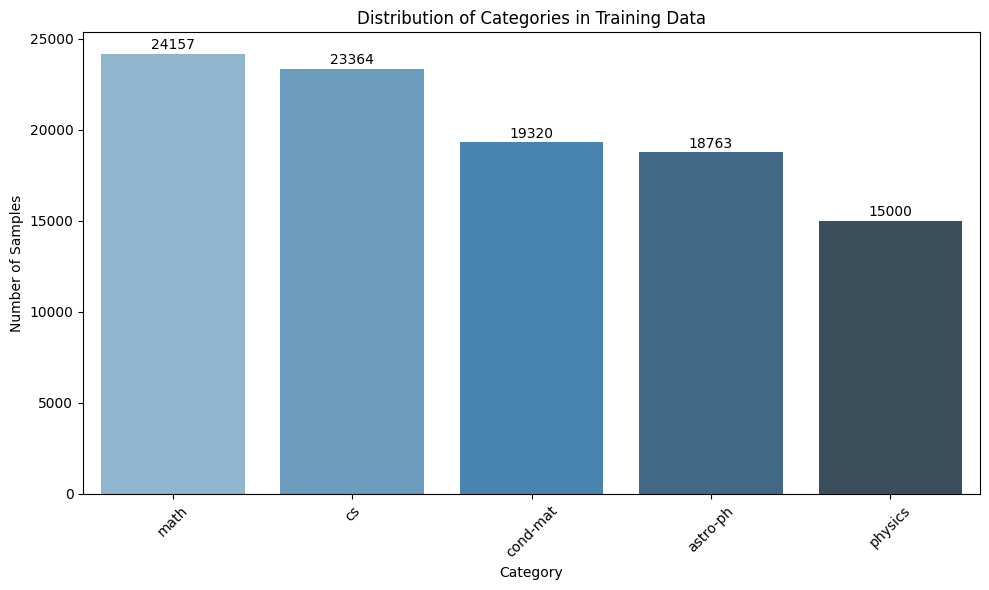

In [ ]:
# Call the function to plot the distribution
plot_category_distribution(sampled_df, 'main_category_temp',
                          title="Distribution of Categories in Training Data",
                          save_path="category_distribution.png")

##Làm sạch dữ liệu

###Hàm tiền xử lý

In [ ]:
# (Có thể thay bằng bộ hàm bạn đã có; đây là bản rút gọn)
_DEFAULT_NEGATIONS = {"no","not","nor","n't","never","none","nobody","nothing","neither","nowhere"}

def strip_latex(text: str) -> str:
    text = re.sub(r"\$[^$]+\$", " ", text)
    text = re.sub(r"\\\[[\s\S]*?\\\]", " ", text)
    text = re.sub(r"\\\([\s\S]*?\\\)", " ", text)
    text = re.sub(r"\\[a-zA-Z]+\{[^{}]*\}", " ", text)
    text = re.sub(r"\\[a-zA-Z]+", " ", text)
    text = re.sub(r"[{}]", " ", text)
    return text

def basic_normalize(text: str) -> str:
    text = text.replace("\\n"," ").replace("\n"," ").replace("\\t"," ").replace("\t"," ")
    text = text.replace("\\'","'").replace('\\"','"')
    text = re.sub(r"(https?://\S+|www\.\S+|\bdoi:\S+)", " ", text, flags=re.IGNORECASE)
    text = re.sub(r"\b\S+@\S+\.\S+\b", " ", text)
    text = re.sub(r"\barXiv:\s*\d{4}\.\d{4,5}(v\d+)?\b", " ", text, flags=re.IGNORECASE)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def remove_punct(text: str, keep_hyphen=True, keep_apos=True) -> str:
    if keep_hyphen and keep_apos:
        text = re.sub(r"[^A-Za-z0-9\s'\-]", " ", text)
    elif keep_hyphen and not keep_apos:
        text = re.sub(r"[^A-Za-z0-9\s\-]", " ", text)
    elif not keep_hyphen and keep_apos:
        text = re.sub(r"[^A-Za-z0-9\s']", " ", text)
    else:
        text = re.sub(r"[^A-Za-z0-9\s]", " ", text)
    return re.sub(r"\s+", " ", text).strip()

# Stopwords/lemmatization (nltk) — vẫn deterministic
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
try:
    _ = stopwords.words("english")
except LookupError:
    nltk.download("stopwords")
    nltk.download("wordnet"); nltk.download("omw-1.4")

EN_STOP = set(w for w in stopwords.words("english") if w not in _DEFAULT_NEGATIONS)
LEMM = WordNetLemmatizer()

def tokenize_simple(text: str):
    return re.findall(r"[A-Za-z]+'?[A-Za-z]+|[A-Za-z]+|\d+", text)

def clean_for_classic(text: str) -> str:
    if text is None: return ""
    text = strip_latex(str(text))
    text = basic_normalize(text).lower()
    text = remove_punct(text, keep_hyphen=True, keep_apos=True)
    toks = tokenize_simple(text)
    toks = [t for t in toks if t not in EN_STOP]
    toks = [LEMM.lemmatize(t) for t in toks]
    return " ".join(toks)

def clean_for_transformer(text: str) -> str:
    if text is None: return ""
    text = strip_latex(str(text))
    text = basic_normalize(text)   # giữ dấu câu/stopwords để bảo toàn ngữ cảnh
    return text

def build_text_column(df, fields=("title","abstract"), sep=". "):
    parts = []
    for col in fields:
        parts.append(df[col].fillna("")) if col in df.columns else parts.append(pd.Series([""]*len(df)))
    text = parts[0].astype(str)
    for p in parts[1:]:
        text = text + sep + p.astype(str)
    return text.str.replace(r"\s+\.\s+\.", ".", regex=True).str.strip()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


###Làm sạch

In [ ]:
# Lựa chọn các cột cần giữ lại
keep_columns = ['id', 'title', 'abstract', 'main_category']
df = sampled_df[keep_columns]

In [ ]:
# 4.1 Gộp text (tùy cột của bạn)
df["text_raw"] = build_text_column(df, fields=("title","abstract"))

# 4.2 Làm sạch deterministic
df["text_classic"]     = df["text_raw"].apply(clean_for_classic)      # cho BoW/TF-IDF
df["text_transformer"] = df["text_raw"].apply(clean_for_transformer)  # cho SBERT/SciBERT/DistilBERT

# 4.3 Bỏ dòng rỗng sau clean (không còn nội dung)
mask_nonempty = df["text_transformer"].str.len().fillna(0) > 0
df = df[mask_nonempty].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100604 entries, 0 to 100603
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                100604 non-null  object
 1   title             100604 non-null  object
 2   abstract          100604 non-null  object
 3   main_category     100604 non-null  object
 4   text_raw          100604 non-null  object
 5   text_classic      100604 non-null  object
 6   text_transformer  100604 non-null  object
dtypes: object(7)
memory usage: 5.4+ MB


##Chia dữ liệu **train/val/test**

In [ ]:
# Chuyển pandas DataFrame sang Hugging Face Dataset
sampled_ds = Dataset.from_pandas(df)

# Lấy các giá trị duy nhất trong cột 'main_category' và chuyển thành ClassLabel
unique_categories = sorted(set(sampled_ds['main_category']))
label_feature = ClassLabel(names=unique_categories)
sampled_ds = sampled_ds.cast_column("main_category", label_feature)

def print_class_distribution(dataset, label_feature, title):
    counts = Counter(dataset["main_category"])
    total = len(dataset)
    print(f"\n📊 {title} (Tổng: {total} mẫu):")
    for class_id, count in sorted(counts.items()):
        label_name = label_feature.int2str(class_id)
        percentage = count / total * 100
        print(f"  - {label_name:<20} : {count:5} mẫu ({percentage:5.2f}%)")

# In phân bố ban đầu
print_class_distribution(sampled_ds, label_feature, "Phân bố lớp ban đầu")

# Chia dữ liệu thành train và test (80% train, 20% test)
split = sampled_ds.train_test_split(
    test_size=0.2,
    stratify_by_column="main_category",
    seed=42
)

# Chia train thành train và validation (80% train, 20% val)
train_val_split = split['train'].train_test_split(
    test_size=0.2,
    stratify_by_column="main_category",
    seed=42
)

train_ds = train_val_split['train']
val_ds = train_val_split['test']
test_ds = split['test']

# In phân bố cho từng tập
print_class_distribution(train_ds, label_feature, "Tập TRAIN")
print_class_distribution(val_ds, label_feature, "Tập VALIDATION")
print_class_distribution(test_ds, label_feature, "Tập TEST")

Casting the dataset:   0%|          | 0/100604 [00:00<?, ? examples/s]


📊 Phân bố lớp ban đầu (Tổng: 100604 mẫu):
  - astro-ph             : 18763 mẫu (18.65%)
  - cond-mat             : 19320 mẫu (19.20%)
  - cs                   : 23364 mẫu (23.22%)
  - math                 : 24157 mẫu (24.01%)
  - physics              : 15000 mẫu (14.91%)

📊 Tập TRAIN (Tổng: 64386 mẫu):
  - astro-ph             : 12008 mẫu (18.65%)
  - cond-mat             : 12365 mẫu (19.20%)
  - cs                   : 14953 mẫu (23.22%)
  - math                 : 15460 mẫu (24.01%)
  - physics              :  9600 mẫu (14.91%)

📊 Tập VALIDATION (Tổng: 16097 mẫu):
  - astro-ph             :  3002 mẫu (18.65%)
  - cond-mat             :  3091 mẫu (19.20%)
  - cs                   :  3738 mẫu (23.22%)
  - math                 :  3866 mẫu (24.02%)
  - physics              :  2400 mẫu (14.91%)

📊 Tập TEST (Tổng: 20121 mẫu):
  - astro-ph             :  3753 mẫu (18.65%)
  - cond-mat             :  3864 mẫu (19.20%)
  - cs                   :  4673 mẫu (23.22%)
  - math                 :  4

####Tải dữ liệu

In [ ]:
# Lưu vào CSV
train_df = train_ds.to_pandas()
train_df['main_category'] = train_df['main_category'].apply(label_feature.int2str)
train_df.to_csv('train.csv', index=False)

val_df = val_ds.to_pandas()
val_df['main_category'] = val_df['main_category'].apply(label_feature.int2str)
val_df.to_csv('validation.csv', index=False)

test_df = test_ds.to_pandas()
test_df['main_category'] = test_df['main_category'].apply(label_feature.int2str)
test_df.to_csv('test.csv', index=False)

In [ ]:
# Tải dữ liệu
# train_df = pd.read_csv('/train.csv')
# val_df = pd.read_csv('/validation.csv')
# test_df = pd.read_csv('/test.csv')

# Chuẩn bị dữ liệu
X_train = train_df['text_classic'].fillna('')
y_train = train_df['main_category']

X_val = val_df['text_classic'].fillna('')
y_val = val_df['main_category']

X_test = test_df['text_classic'].fillna('')
y_test = test_df['main_category']

# Mã hóa nhãn (nếu cần, vì các model scikit-learn chấp nhận string labels, nhưng để an toàn)
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

print(f"Kích thước train: {X_train.shape}, validation: {X_val.shape}, test: {X_test.shape}")

Kích thước train: (64386,), validation: (16097,), test: (20121,)


In [ ]:
print("LabelEncoder mapping (class_id -> class_name):")
print({i: name for i, name in enumerate(label_encoder.classes_)})

LabelEncoder mapping (class_id -> class_name):
{0: 'astro-ph', 1: 'cond-mat', 2: 'cs', 3: 'math', 4: 'physics'}


##Huấn luyện mô hình


###Bag of Word và TF-IDF

####Vector Hóa Văn Bản Với BoW (Bag-of-Words)

In [ ]:
# Vector hóa BoW
bow_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)
X_test_bow = bow_vectorizer.transform(X_test)

print(f"Kích thước vector BoW: {X_train_bow.shape}")

Kích thước vector BoW: (64386, 5000)


####Vector Hóa Văn Bản Với TF-IDF

In [ ]:
# Vector hóa TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Kích thước vector TF-IDF: {X_train_tfidf.shape}")

Kích thước vector TF-IDF: (64386, 5000)


####Hàm Đánh Giá Mô Hình

In [ ]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    # Huấn luyện
    model.fit(X_train, y_train)

    # Dự đoán validation
    y_val_pred = model.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='macro')

    # Dự đoán test
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='macro')

    print(f"\n=== {model_name} ===")
    print(f"Validation Accuracy: {val_acc:.4f}, Macro F1: {val_f1:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}, Macro F1: {test_f1:.4f}")
    print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))

    # Confusion Matrix with counts and percentages
    cm = confusion_matrix(y_test, y_test_pred)
    row_sums = cm.sum(axis=1)
    cm_norm = cm / row_sums[:, np.newaxis] * 100  # Row-normalized percentages
    annot = np.array([f"{cm[i,j]}\n({cm_norm[i,j]:.1f}%)" for i in range(cm.shape[0]) for j in range(cm.shape[1])]).reshape(cm.shape)

    # Create heatmap without default color bar
    plt.figure(figsize=(8,6))
    heatmap = sns.heatmap(cm_norm, annot=annot, fmt='', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, vmin=0, vmax=100, cbar=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.colorbar(heatmap.get_children()[0], label='Percentage Accuracy (%)')  # Add custom color bar
    plt.show()

    return test_acc, test_f1

####Huấn Luyện Và Đánh Giá Với BoW


=== BoW + Naive Bayes ===
Validation Accuracy: 0.8784, Macro F1: 0.8713
Test Accuracy: 0.8728, Macro F1: 0.8647

Classification Report (Test):
               precision    recall  f1-score   support

    astro-ph       0.97      0.92      0.95      3753
    cond-mat       0.89      0.85      0.87      3864
          cs       0.88      0.90      0.89      4673
        math       0.88      0.92      0.90      4831
     physics       0.71      0.72      0.72      3000

    accuracy                           0.87     20121
   macro avg       0.87      0.86      0.86     20121
weighted avg       0.87      0.87      0.87     20121



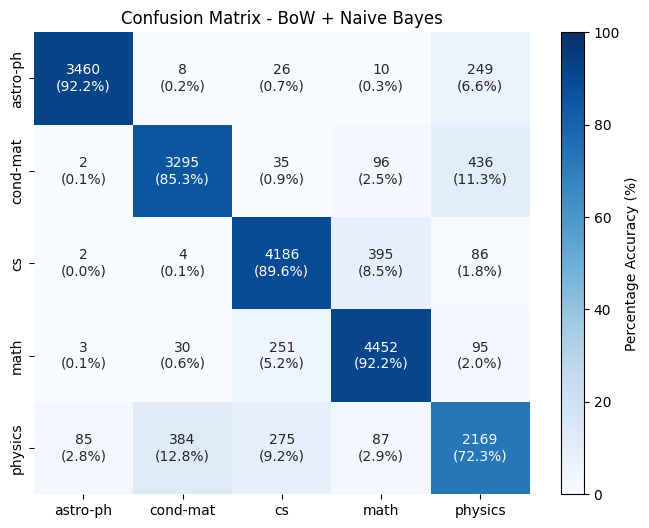


=== BoW + KNN ===
Validation Accuracy: 0.8320, Macro F1: 0.8143
Test Accuracy: 0.8356, Macro F1: 0.8176

Classification Report (Test):
               precision    recall  f1-score   support

    astro-ph       0.90      0.94      0.92      3753
    cond-mat       0.81      0.84      0.82      3864
          cs       0.84      0.89      0.86      4673
        math       0.84      0.90      0.87      4831
     physics       0.75      0.52      0.62      3000

    accuracy                           0.84     20121
   macro avg       0.83      0.82      0.82     20121
weighted avg       0.83      0.84      0.83     20121



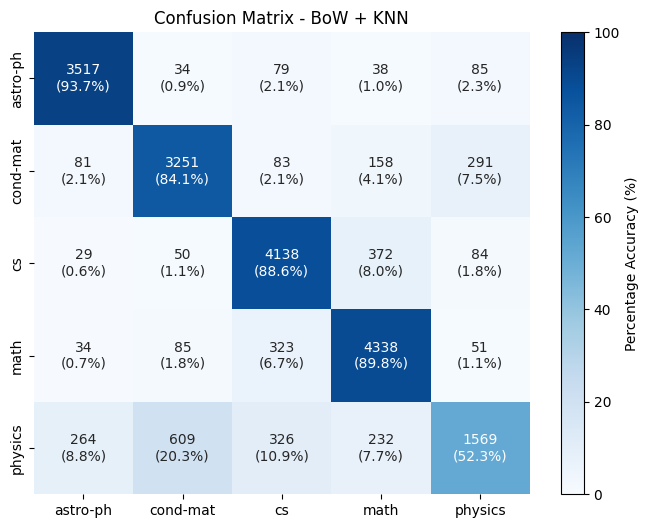


=== BoW + Decision Tree ===
Validation Accuracy: 0.7071, Macro F1: 0.6934
Test Accuracy: 0.7029, Macro F1: 0.6894

Classification Report (Test):
               precision    recall  f1-score   support

    astro-ph       0.92      0.78      0.84      3753
    cond-mat       0.66      0.69      0.68      3864
          cs       0.78      0.74      0.76      4673
        math       0.73      0.78      0.75      4831
     physics       0.40      0.43      0.41      3000

    accuracy                           0.70     20121
   macro avg       0.70      0.69      0.69     20121
weighted avg       0.71      0.70      0.71     20121



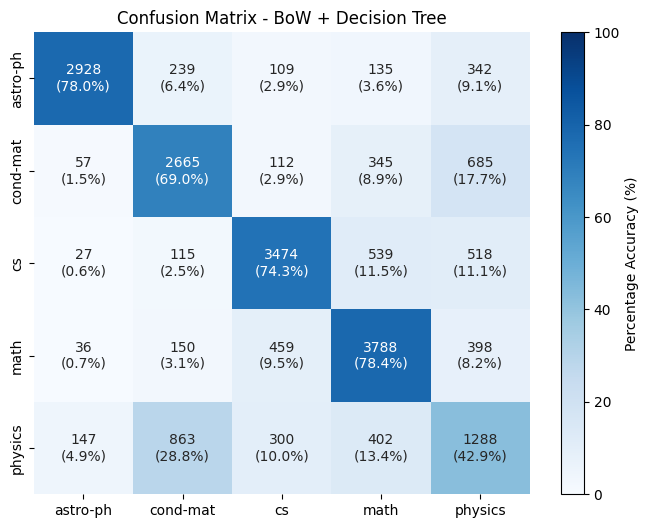

(0.7028974703046569, 0.6894228131807275)

In [ ]:
# Naive Bayes với BoW
nb_bow = MultinomialNB()
evaluate_model(nb_bow, X_train_bow, y_train, X_val_bow, y_val, X_test_bow, y_test, "BoW + Naive Bayes")

# KNN với BoW (sử dụng k=5, cosine distance cho text)
knn_bow = KNeighborsClassifier(n_neighbors=5, metric='cosine')
evaluate_model(knn_bow, X_train_bow, y_train, X_val_bow, y_val, X_test_bow, y_test, "BoW + KNN")

# Decision Tree với BoW (giới hạn depth để tránh overfit)
dt_bow = DecisionTreeClassifier(max_depth=20, random_state=42)
evaluate_model(dt_bow, X_train_bow, y_train, X_val_bow, y_val, X_test_bow, y_test, "BoW + Decision Tree")

####Huấn Luyện Và Đánh Giá Với TF-IDF


=== TF-IDF + Naive Bayes ===
Validation Accuracy: 0.8790, Macro F1: 0.8693
Test Accuracy: 0.8742, Macro F1: 0.8630

Classification Report (Test):
               precision    recall  f1-score   support

    astro-ph       0.97      0.94      0.95      3753
    cond-mat       0.87      0.89      0.88      3864
          cs       0.86      0.91      0.88      4673
        math       0.88      0.92      0.90      4831
     physics       0.77      0.65      0.70      3000

    accuracy                           0.87     20121
   macro avg       0.87      0.86      0.86     20121
weighted avg       0.87      0.87      0.87     20121



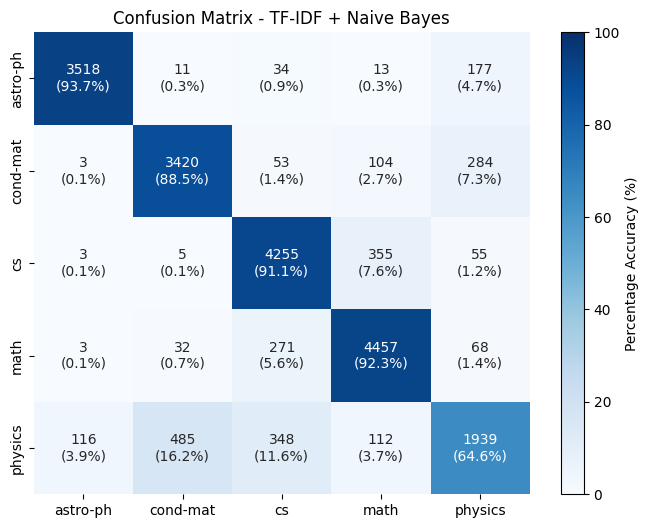


=== TF-IDF + KNN ===
Validation Accuracy: 0.8317, Macro F1: 0.8145
Test Accuracy: 0.8342, Macro F1: 0.8173

Classification Report (Test):
               precision    recall  f1-score   support

    astro-ph       0.90      0.95      0.92      3753
    cond-mat       0.81      0.85      0.83      3864
          cs       0.84      0.87      0.86      4673
        math       0.83      0.89      0.86      4831
     physics       0.75      0.53      0.62      3000

    accuracy                           0.83     20121
   macro avg       0.83      0.82      0.82     20121
weighted avg       0.83      0.83      0.83     20121



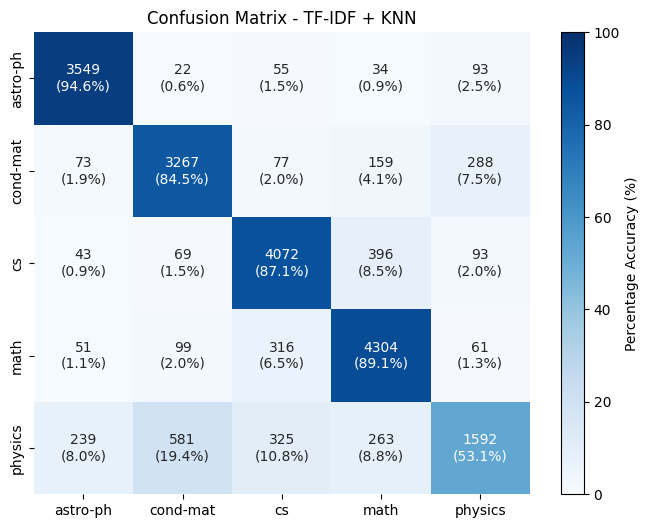


=== TF-IDF + Decision Tree ===
Validation Accuracy: 0.7022, Macro F1: 0.6934
Test Accuracy: 0.7013, Macro F1: 0.6924

Classification Report (Test):
               precision    recall  f1-score   support

    astro-ph       0.92      0.77      0.84      3753
    cond-mat       0.70      0.65      0.67      3864
          cs       0.79      0.73      0.76      4673
        math       0.72      0.79      0.75      4831
     physics       0.40      0.50      0.44      3000

    accuracy                           0.70     20121
   macro avg       0.70      0.69      0.69     20121
weighted avg       0.72      0.70      0.71     20121



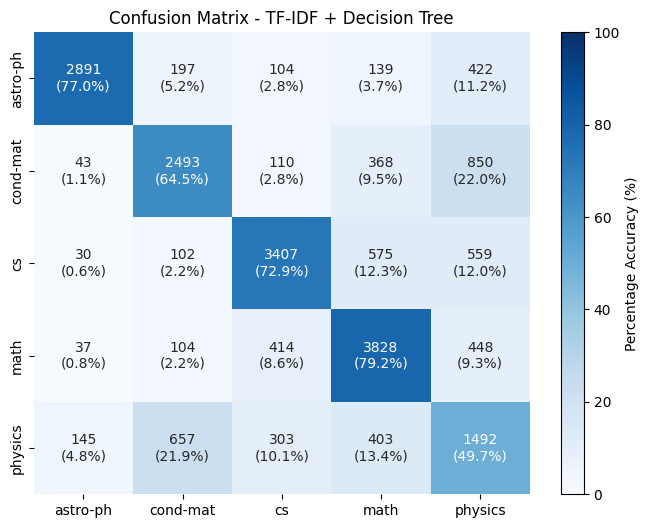

(0.7013070920928384, 0.6923907338121355)

In [ ]:
# Naive Bayes với TF-IDF
nb_tfidf = MultinomialNB()
evaluate_model(nb_tfidf, X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, "TF-IDF + Naive Bayes")

# KNN với TF-IDF
knn_tfidf = KNeighborsClassifier(n_neighbors=5, metric='cosine')
evaluate_model(knn_tfidf, X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, "TF-IDF + KNN")

# Decision Tree với TF-IDF
dt_tfidf = DecisionTreeClassifier(max_depth=20, random_state=42)
evaluate_model(dt_tfidf, X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, "TF-IDF + Decision Tree")

####K-fold và Cross-Validation cho BoW + TF-IDF

#####Hàm đánh giá

In [ ]:
# Define KNN parameter grid
knn_params = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'weights': ['uniform', 'distance']}

# Enhanced evaluate_model function with best parameters in title
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name, best_params=None, label_encoder=None):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='macro')
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='macro')

    print(f"\n=== {model_name} ===")
    print(f"Validation Accuracy: {val_acc:.4f}, Macro F1: {val_f1:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}, Macro F1: {test_f1:.4f}")
    print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))

    cm = confusion_matrix(y_test, y_test_pred)
    row_sums = cm.sum(axis=1)
    cm_norm = cm / row_sums[:, np.newaxis] * 100
    annot = np.array([f"{cm[i,j]}\n({cm_norm[i,j]:.1f}%)" for i in range(cm.shape[0]) for j in range(cm.shape[1])]).reshape(cm.shape)

    plt.figure(figsize=(8,6))
    heatmap = sns.heatmap(cm_norm, annot=annot, fmt='', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, vmin=0, vmax=100, cbar=False)
    title = f"Confusion Matrix - {model_name}"
    if best_params and 'n_neighbors' in best_params:
        title += f" (Best K = {best_params['n_neighbors']})"
    plt.title(title)
    plt.colorbar(heatmap.get_children()[0], label='Percentage Accuracy (%)')
    plt.show()

    return test_acc, test_f1

In [ ]:
print(f"BoW Train shape: {X_train_bow.shape}, TF-IDF Train shape: {X_train_tfidf.shape}")

BoW Train shape: (64386, 5000), TF-IDF Train shape: (64386, 5000)


#####Tune KNN with BoW

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best KNN params for BoW: {'n_neighbors': 13, 'weights': 'distance'}

Benchmark Results for KNN (BoW):
K = 3: Mean Macro F1 = 0.8017 (± 0.0021)
K = 5: Mean Macro F1 = 0.8107 (± 0.0014)
K = 7: Mean Macro F1 = 0.8134 (± 0.0016)
K = 9: Mean Macro F1 = 0.8144 (± 0.0019)
K = 11: Mean Macro F1 = 0.8157 (± 0.0017)
K = 13: Mean Macro F1 = 0.8164 (± 0.0021)
K = 15: Mean Macro F1 = 0.8160 (± 0.0013)


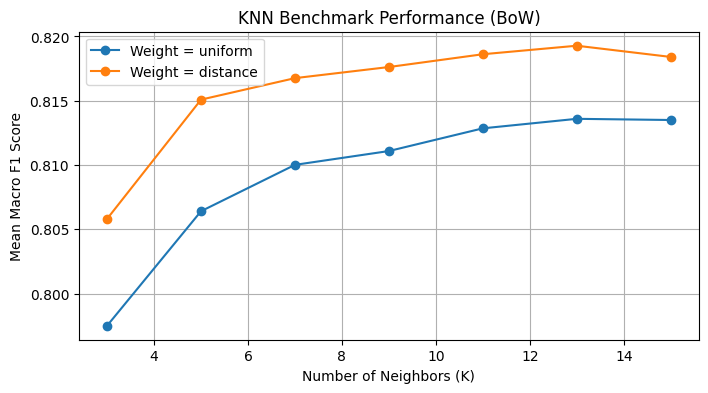

In [ ]:
# Tune KNN with BoW
knn_grid_bow = GridSearchCV(KNeighborsClassifier(metric='cosine'), knn_params, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
knn_grid_bow.fit(X_train_bow, y_train)
best_knn_bow = knn_grid_bow.best_estimator_
print(f"Best KNN params for BoW: {knn_grid_bow.best_params_}")

# Display benchmark results for each K value
print("\nBenchmark Results for KNN (BoW):")
results = knn_grid_bow.cv_results_
for k in [3, 5, 7, 9, 11, 13, 15]:
    mask = results['param_n_neighbors'] == k
    mean_f1 = results['mean_test_score'][mask].mean()
    std_f1 = results['std_test_score'][mask].mean()
    print(f"K = {k}: Mean Macro F1 = {mean_f1:.4f} (± {std_f1:.4f})")

# Plot benchmark F1-scores for K values
plt.figure(figsize=(8, 4))
for weight in ['uniform', 'distance']:
    mask = results['param_weights'] == weight
    plt.plot([3, 5, 7, 9, 11, 13, 15], [results['mean_test_score'][i] for i in np.where(mask)[0]], marker='o', label=f'Weight = {weight}')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Mean Macro F1 Score')
plt.title('KNN Benchmark Performance (BoW)')
plt.legend()
plt.grid(True)
plt.show()

#####Đánh giá lại KNN với BoW (sử dụng K tối ưu)


=== BoW + Tuned KNN ===
Validation Accuracy: 0.8414, Macro F1: 0.8270
Test Accuracy: 0.8428, Macro F1: 0.8276

Classification Report (Test):
               precision    recall  f1-score   support

    astro-ph       0.92      0.93      0.93      3753
    cond-mat       0.83      0.84      0.84      3864
          cs       0.84      0.89      0.86      4673
        math       0.83      0.91      0.87      4831
     physics       0.77      0.56      0.65      3000

    accuracy                           0.84     20121
   macro avg       0.84      0.83      0.83     20121
weighted avg       0.84      0.84      0.84     20121



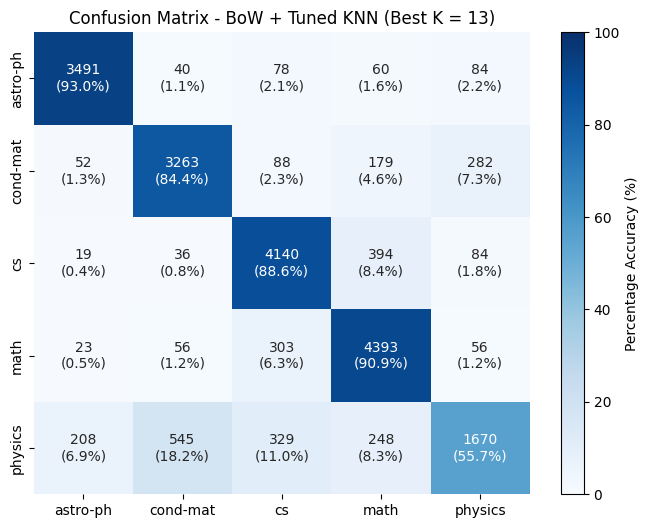

(0.842751354306446, 0.8275531171767062)

In [ ]:
# Evaluate the best KNN model with BoW
evaluate_model(best_knn_bow, X_train_bow, y_train, X_val_bow, y_val, X_test_bow, y_test, "BoW + Tuned KNN", best_params=knn_grid_bow.best_params_, label_encoder=label_encoder)

#####Tune KNN with TF-IDF

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best KNN params for TF-IDF: {'n_neighbors': 15, 'weights': 'distance'}

Benchmark Results for KNN (TF-IDF):
K = 3: Mean Macro F1 = 0.8018 (± 0.0021)
K = 5: Mean Macro F1 = 0.8129 (± 0.0028)
K = 7: Mean Macro F1 = 0.8170 (± 0.0020)
K = 9: Mean Macro F1 = 0.8201 (± 0.0009)
K = 11: Mean Macro F1 = 0.8206 (± 0.0003)
K = 13: Mean Macro F1 = 0.8217 (± 0.0003)
K = 15: Mean Macro F1 = 0.8233 (± 0.0012)


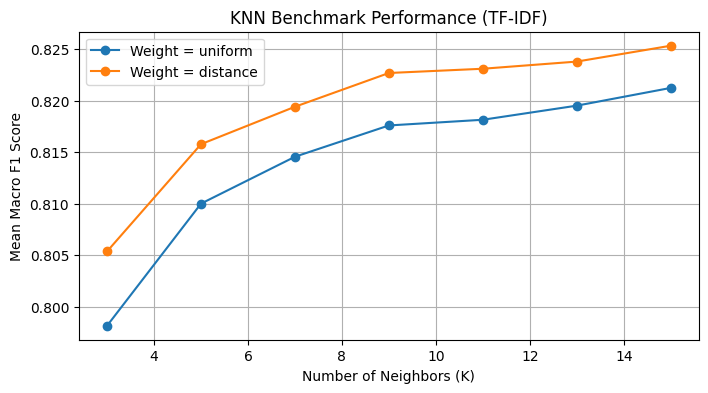

In [ ]:
# Tune KNN with TF-IDF
knn_grid_tfidf = GridSearchCV(KNeighborsClassifier(metric='cosine'), knn_params, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
knn_grid_tfidf.fit(X_train_tfidf, y_train)
best_knn_tfidf = knn_grid_tfidf.best_estimator_
print(f"Best KNN params for TF-IDF: {knn_grid_tfidf.best_params_}")

# Display benchmark results for each K value
print("\nBenchmark Results for KNN (TF-IDF):")
results = knn_grid_tfidf.cv_results_
for k in [3, 5, 7, 9, 11, 13, 15]:
    mask = results['param_n_neighbors'] == k
    mean_f1 = results['mean_test_score'][mask].mean()
    std_f1 = results['std_test_score'][mask].mean()
    print(f"K = {k}: Mean Macro F1 = {mean_f1:.4f} (± {std_f1:.4f})")

# Plot benchmark F1-scores for K values
plt.figure(figsize=(8, 4))
for weight in ['uniform', 'distance']:
    mask = results['param_weights'] == weight
    plt.plot([3, 5, 7, 9, 11, 13, 15], [results['mean_test_score'][i] for i in np.where(mask)[0]], marker='o', label=f'Weight = {weight}')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Mean Macro F1 Score')
plt.title('KNN Benchmark Performance (TF-IDF)')
plt.legend()
plt.grid(True)
plt.show()

#####Đánh giá lại KNN với TF-IDF (sử dụng K tối ưu)


=== TF-IDF + Tuned KNN ===
Validation Accuracy: 0.8451, Macro F1: 0.8311
Test Accuracy: 0.8439, Macro F1: 0.8287

Classification Report (Test):
               precision    recall  f1-score   support

    astro-ph       0.92      0.95      0.93      3753
    cond-mat       0.83      0.85      0.84      3864
          cs       0.85      0.88      0.86      4673
        math       0.83      0.90      0.87      4831
     physics       0.76      0.56      0.64      3000

    accuracy                           0.84     20121
   macro avg       0.84      0.83      0.83     20121
weighted avg       0.84      0.84      0.84     20121



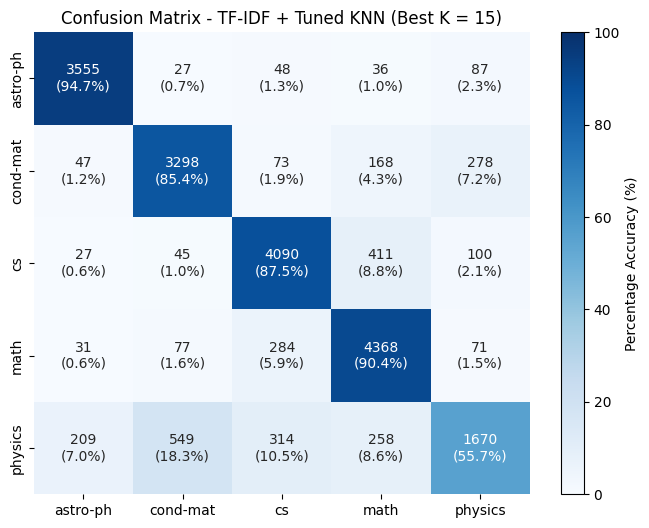

(0.8439441379653099, 0.8287242886468157)

In [ ]:
# Evaluate the best KNN model with TF-IDF
evaluate_model(best_knn_tfidf, X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, "TF-IDF + Tuned KNN", best_params=knn_grid_tfidf.best_params_, label_encoder=label_encoder)

####K-Means với BoW và TF-IDF


--- KMeans (BoW) ---


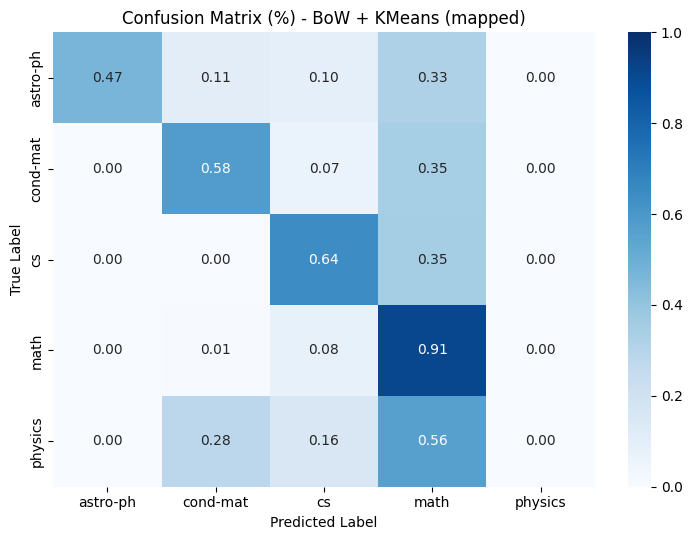

Cluster ID -> Mapped class: {0: 'cs', 1: 'math', 2: 'cs', 3: 'cond-mat', 4: 'astro-ph'}

--- KMeans (TF-IDF) ---


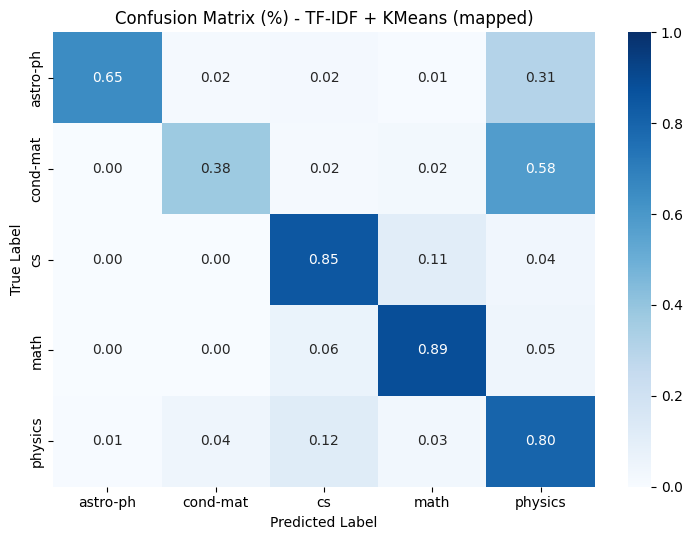

Cluster ID -> Mapped class: {0: 'math', 1: 'cs', 2: 'astro-ph', 3: 'cond-mat', 4: 'physics'}


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

def majority_map_clusters_to_classes(y_true_int, y_pred_clusters, n_classes=5):
    cm = confusion_matrix(y_true_int, y_pred_clusters, labels=range(n_classes))
    # Với mỗi cluster (cột), chọn class (hàng) có count lớn nhất
    mapping = np.argmax(cm, axis=0)  # shape = (n_clusters,)
    return mapping, cm

def evaluate_kmeans_simple(X_train, X_test, y_test_enc, method_name="BoW", random_state=42):
    print(f"\n--- KMeans ({method_name}) ---")
    n_classes = len(label_encoder.classes_)
    kmeans = KMeans(n_clusters=n_classes, random_state=random_state, n_init=10)
    kmeans.fit(X_train)
    y_pred_clusters = kmeans.predict(X_test)

    # Ánh xạ cluster -> class_id bằng majority vote
    mapping, cm_clusters = majority_map_clusters_to_classes(y_test_enc, y_pred_clusters, n_classes)
    # Remap dự đoán sang class_id để dễ đọc/so sánh
    y_pred_class = mapping[y_pred_clusters]

    # Confusion theo class_id (đã map), chuẩn hóa theo hàng để đọc % dễ
    cm = confusion_matrix(y_test_enc, y_pred_class, labels=range(n_classes)).astype(float)
    row_sum = cm.sum(axis=1, keepdims=True)
    cm_pct = np.divide(cm, np.where(row_sum==0, 1, row_sum))  # tránh chia 0

    import seaborn as sns, matplotlib.pyplot as plt
    plt.figure(figsize=(7.5, 5.5))
    sns.heatmap(cm_pct, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, vmin=0, vmax=1)
    plt.title(f"Confusion Matrix (%) - {method_name} + KMeans (mapped)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # In bảng tra cluster_id -> class_name để ai cần vẫn soi chiếu được
    cluster_to_class = {cluster_id: label_encoder.classes_[cls_id]
                        for cluster_id, cls_id in enumerate(mapping)}
    print("Cluster ID -> Mapped class:", cluster_to_class)

# Gọi:
evaluate_kmeans_simple(X_train_bow,   X_test_bow,   y_test_enc, method_name="BoW")
evaluate_kmeans_simple(X_train_tfidf, X_test_tfidf, y_test_enc, method_name="TF-IDF")


###Sentence Embedding

####Tạo embedding và lưu caches

In [ ]:
# === SENTENCE EMBEDDING: build & cache ===
from sentence_transformers import SentenceTransformer
import os, gc, time

# 1. Chọn model
SE_MODEL_NAME = "sentence-transformers/allenai-specter"  # 768b
BATCH_SIZE = 256
os.makedirs(CACHE_DIR, exist_ok=True)

def encode_texts(model, texts, batch_size=256, normalize=True, to_dtype=np.float32):
    # texts: pandas Series hoặc list[str]
    emb = model.encode(
        texts.tolist(),
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=normalize,
    )
    if to_dtype is not None:
        emb = emb.astype(to_dtype, copy=False)
    return emb

# 2. Dùng cột đã chuẩn bị cho transformer
X_train_tx = train_df["text_transformer"].fillna("")
X_val_tx   = val_df["text_transformer"].fillna("")
X_test_tx  = test_df["text_transformer"].fillna("")

print("Loading SentenceTransformer:", SE_MODEL_NAME)
se_model = SentenceTransformer(SE_MODEL_NAME)

t0 = time.time()
E_train = encode_texts(se_model, X_train_tx, batch_size=BATCH_SIZE)
E_val   = encode_texts(se_model, X_val_tx,   batch_size=BATCH_SIZE)
E_test  = encode_texts(se_model, X_test_tx,  batch_size=BATCH_SIZE)
print(f"Embeddings shapes: train={E_train.shape}, val={E_val.shape}, test={E_test.shape}")

# 3. Lưu cache để dùng lại
np.savez_compressed(os.path.join(CACHE_DIR, f"emb_{SE_MODEL_NAME.replace('/','-')}.npz"),
                    E_train=E_train, E_val=E_val, E_test=E_test,
                    y_train=y_train_enc, y_val=y_val_enc, y_test=y_test_enc)
del se_model; gc.collect()


Loading SentenceTransformer: sentence-transformers/allenai-specter


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/331 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/252 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Embeddings shapes: train=(64386, 768), val=(16097, 768), test=(20121, 768)


3701

####KNN, Logistic Regression, LinearSCV và Sentence Embedding


=== SE (sentence-transformers/allenai-specter) + LogisticRegression ===
Val  Acc=0.9045  Macro-F1=0.8971
Test Acc=0.8993  Macro-F1=0.8916
Classification report (Test):
               precision    recall  f1-score   support

    astro-ph       0.97      0.97      0.97      3753
    cond-mat       0.88      0.89      0.88      3864
          cs       0.91      0.93      0.92      4673
        math       0.92      0.92      0.92      4831
     physics       0.79      0.75      0.77      3000

    accuracy                           0.90     20121
   macro avg       0.89      0.89      0.89     20121
weighted avg       0.90      0.90      0.90     20121



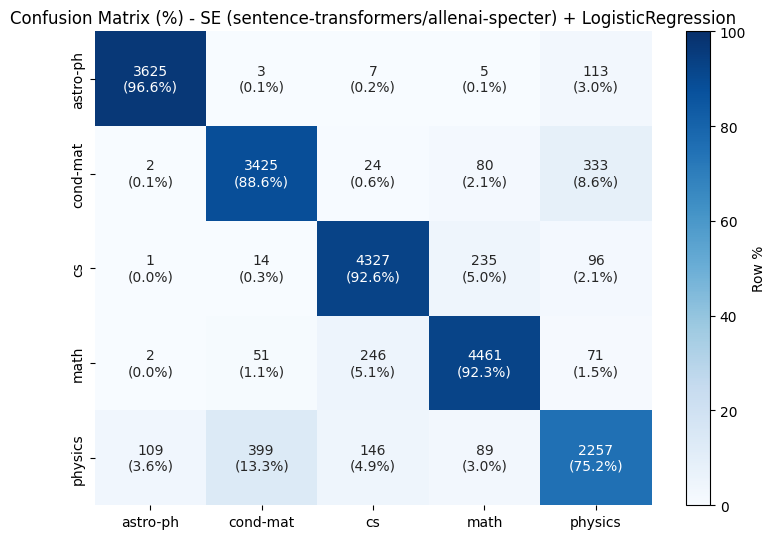


=== SE (sentence-transformers/allenai-specter) + LinearSVC ===
Val  Acc=0.9105  Macro-F1=0.9034
Test Acc=0.9026  Macro-F1=0.8948
Classification report (Test):
               precision    recall  f1-score   support

    astro-ph       0.97      0.97      0.97      3753
    cond-mat       0.88      0.89      0.89      3864
          cs       0.91      0.93      0.92      4673
        math       0.92      0.93      0.92      4831
     physics       0.80      0.75      0.78      3000

    accuracy                           0.90     20121
   macro avg       0.90      0.89      0.89     20121
weighted avg       0.90      0.90      0.90     20121



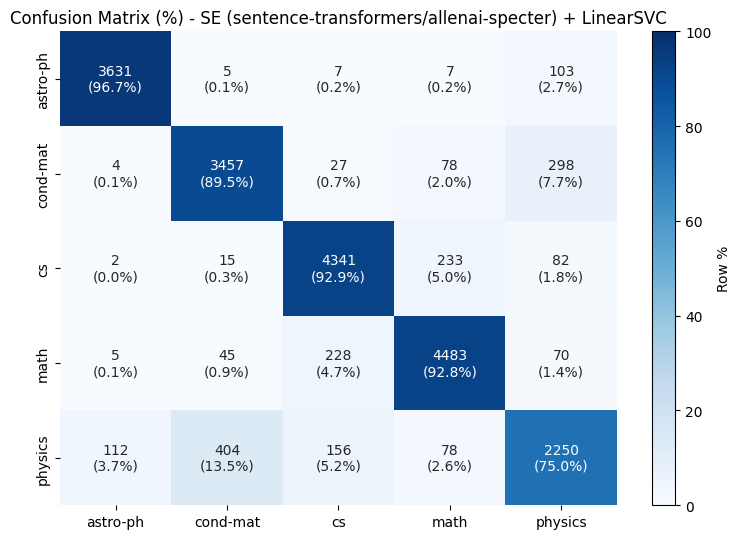


=== SE (sentence-transformers/allenai-specter) + KNN(cosine) ===
Val  Acc=0.9045  Macro-F1=0.8967
Test Acc=0.9052  Macro-F1=0.8967
Classification report (Test):
               precision    recall  f1-score   support

    astro-ph       0.96      0.98      0.97      3753
    cond-mat       0.87      0.91      0.89      3864
          cs       0.94      0.92      0.93      4673
        math       0.91      0.94      0.92      4831
     physics       0.82      0.73      0.77      3000

    accuracy                           0.91     20121
   macro avg       0.90      0.90      0.90     20121
weighted avg       0.90      0.91      0.90     20121



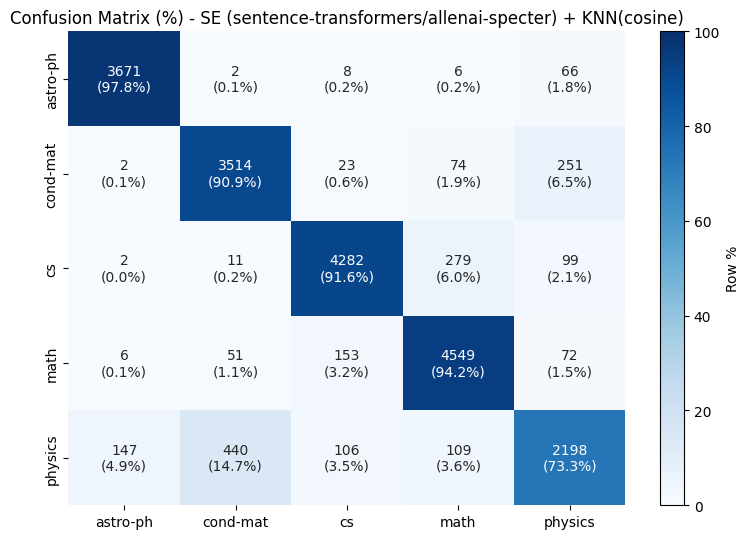

In [ ]:
# === CLASSIFICATION on sentence embeddings ===

# Nếu đã có E_train/E_val/E_test trong RAM thì dùng luôn; nếu không thì load NPZ:
# data = np.load(os.path.join(EMB_DIR, f"emb_{SE_MODEL_NAME.replace('/','-')}.npz"))
# E_train, E_val, E_test = data["E_train"], data["E_val"], data["E_test"]
# y_train_enc, y_val_enc, y_test_enc = data["y_train"], data["y_val"], data["y_test"]

def eval_cls(model, Xtr, ytr, Xva, yva, Xte, yte, name):
    model.fit(Xtr, ytr)
    pred_v = model.predict(Xva); pred_t = model.predict(Xte)
    acc_v, f1_v = accuracy_score(yva, pred_v), f1_score(yva, pred_v, average="macro")
    acc_t, f1_t = accuracy_score(yte, pred_t), f1_score(yte, pred_t, average="macro")
    print(f"\n=== {name} ===")
    print(f"Val  Acc={acc_v:.4f}  Macro-F1={f1_v:.4f}")
    print(f"Test Acc={acc_t:.4f}  Macro-F1={f1_t:.4f}")
    print("Classification report (Test):\n", classification_report(yte, pred_t, target_names=label_encoder.classes_))
    # CM (%) theo hàng, annot count + %
    cm = confusion_matrix(yte, pred_t, labels=range(len(label_encoder.classes_)))
    cm_pct = (cm / cm.sum(axis=1, keepdims=True) * 100).round(1)
    annot = np.array([f"{cm[i,j]}\n({cm_pct[i,j]:.1f}%)" for i in range(cm.shape[0]) for j in range(cm.shape[1])]).reshape(cm.shape)
    plt.figure(figsize=(7.5,5.5))
    ax = sns.heatmap(cm_pct, annot=annot, fmt="", cmap="Blues",
                     xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, vmin=0, vmax=100, cbar=False)
    plt.title(f"Confusion Matrix (%) - {name}")
    plt.colorbar(ax.get_children()[0], label="Row %")
    plt.tight_layout(); plt.show()

# 1) Logistic Regression (multinomial) — thường rất mạnh trên embedding
logreg = LogisticRegression(max_iter=2000, multi_class="multinomial", n_jobs=None)
eval_cls(logreg, E_train, y_train_enc, E_val, y_val_enc, E_test, y_test_enc, f"SE ({SE_MODEL_NAME}) + LogisticRegression")

# 2) LinearSVC — nhanh, thường mạnh trên embedding
lsvc = LinearSVC()
eval_cls(lsvc, E_train, y_train_enc, E_val, y_val_enc, E_test, y_test_enc, f"SE ({SE_MODEL_NAME}) + LinearSVC")

# 3) KNN (cosine) — cần normalize embedding (đã normalize ở bước encode)
knn = KNeighborsClassifier(n_neighbors=7, metric="cosine", weights="distance")
eval_cls(knn, E_train, y_train_enc, E_val, y_val_enc, E_test, y_test_enc, f"SE ({SE_MODEL_NAME}) + KNN(cosine)")

####K-Means và Sentence Embedding


--- KMeans (sentence-transformers/allenai-specter) ---
ARI=0.5550  NMI=0.5827  H=0.5817  C=0.5836  V=0.5827


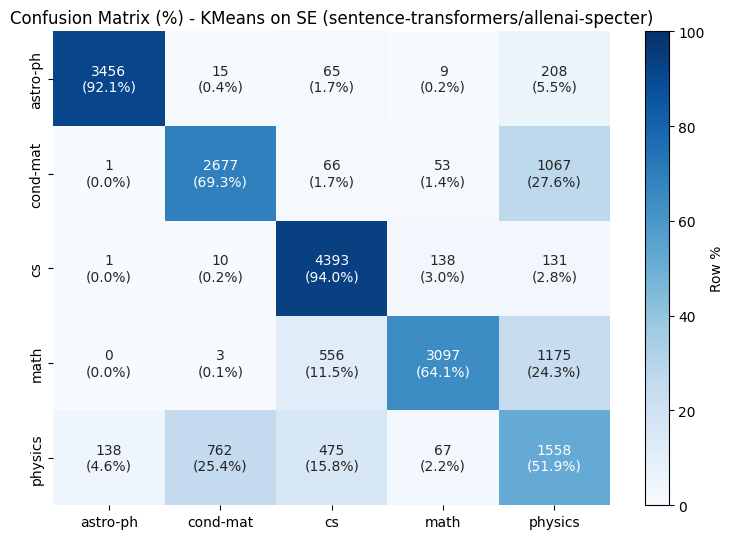

Cluster ID -> mapped class: {0: 'math', 1: 'cond-mat', 2: 'physics', 3: 'astro-ph', 4: 'cs'}


In [ ]:
# === KMEANS on sentence embeddings ===
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score

def majority_map_clusters_to_classes(y_true_int, y_pred_clusters, n_classes):
    cm = confusion_matrix(y_true_int, y_pred_clusters, labels=range(n_classes))
    mapping = np.argmax(cm, axis=0)   # cluster j -> class argmax over rows
    return mapping, cm

def eval_kmeans_embeddings(Xtr, Xte, y_test_int, method_name):
    kmeans = KMeans(n_clusters=len(label_encoder.classes_), random_state=42, n_init=10)
    kmeans.fit(Xtr)
    y_pred_cl = kmeans.predict(Xte)

    # Metrics (giữ “thô” để khách quan)
    ari = adjusted_rand_score(y_test_int, y_pred_cl)
    nmi = normalized_mutual_info_score(y_test_int, y_pred_cl)
    h   = homogeneity_score(y_test_int, y_pred_cl)
    c   = completeness_score(y_test_int, y_pred_cl)
    v   = v_measure_score(y_test_int, y_pred_cl)
    print(f"\n--- KMeans ({method_name}) ---\nARI={ari:.4f}  NMI={nmi:.4f}  H={h:.4f}  C={c:.4f}  V={v:.4f}")

    # Map cluster -> class (majority vote) để hiển thị nhãn thật
    mapping, _ = majority_map_clusters_to_classes(y_test_int, y_pred_cl, len(label_encoder.classes_))
    y_pred_cls = mapping[y_pred_cl]

    cm = confusion_matrix(y_test_int, y_pred_cls, labels=range(len(label_encoder.classes_))).astype(float)
    cm_pct = (cm / cm.sum(axis=1, keepdims=True) * 100)
    annot = np.array([f"{int(cm[i,j])}\n({cm_pct[i,j]:.1f}%)" for i in range(cm.shape[0]) for j in range(cm.shape[1])]).reshape(cm.shape)

    plt.figure(figsize=(7.5,5.5))
    ax = sns.heatmap(cm_pct, annot=annot, fmt="", cmap="Blues",
                     xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, vmin=0, vmax=100, cbar=False)
    plt.title(f"Confusion Matrix (%) - KMeans on SE ({method_name})")
    plt.colorbar(ax.get_children()[0], label="Row %"); plt.tight_layout(); plt.show()

    # In mapping để đối chiếu
    print("Cluster ID -> mapped class:", {cid: label_encoder.classes_[cls] for cid, cls in enumerate(mapping)})

eval_kmeans_embeddings(E_train, E_test, y_test_enc, f"{SE_MODEL_NAME}")


####K-Fold + Cross Validation chọn best K

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best KNN params for SE (sentence-transformers/allenai-specter): {'n_neighbors': 15, 'weights': 'distance'}

Benchmark Results for KNN (SE (sentence-transformers/allenai-specter)):
K = 3: Mean Macro F1 = 0.8817 (± 0.0017)
K = 5: Mean Macro F1 = 0.8892 (± 0.0009)
K = 7: Mean Macro F1 = 0.8921 (± 0.0010)
K = 9: Mean Macro F1 = 0.8927 (± 0.0008)
K = 11: Mean Macro F1 = 0.8929 (± 0.0011)
K = 13: Mean Macro F1 = 0.8931 (± 0.0014)
K = 15: Mean Macro F1 = 0.8932 (± 0.0014)
K = 17: Mean Macro F1 = 0.8925 (± 0.0016)
K = 19: Mean Macro F1 = 0.8929 (± 0.0019)
K = 21: Mean Macro F1 = 0.8932 (± 0.0015)
K = 23: Mean Macro F1 = 0.8926 (± 0.0016)
K = 25: Mean Macro F1 = 0.8929 (± 0.0010)
K = 27: Mean Macro F1 = 0.8927 (± 0.0010)
K = 29: Mean Macro F1 = 0.8920 (± 0.0012)
K = 31: Mean Macro F1 = 0.8915 (± 0.0009)


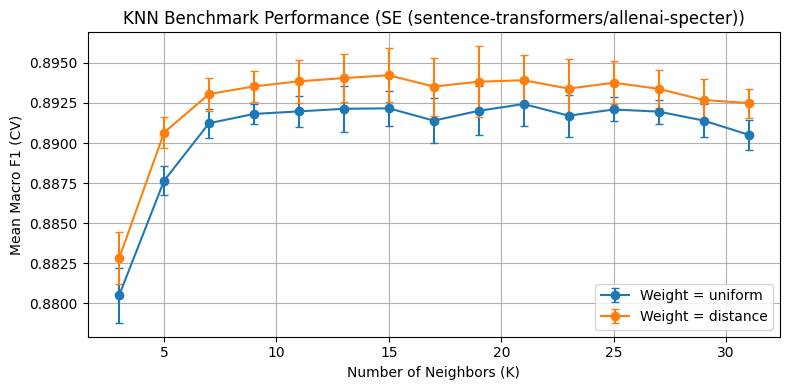


Best KNN (SE (sentence-transformers/allenai-specter)) — Validation:  Acc=0.9068  Macro-F1=0.8989
Best KNN (SE (sentence-transformers/allenai-specter)) — Test:         Acc=0.9079 Macro-F1=0.8995


In [ ]:
# ==== Tune KNN on Sentence Embeddings (GridSearchCV) ====
# Nếu cần: load cache embeddings đã lưu trước đó
# import os
# npz_path = os.path.join("./emb_cache", f"emb_{SE_MODEL_NAME.replace('/','-')}.npz")
# if 'E_train' not in globals():
#     data = np.load(npz_path)
#     E_train, E_val, E_test = data["E_train"], data["E_val"], data["E_test"]
#     y_train, y_val, y_test = data["y_train"], data["y_val"], data["y_test"]  # có thể là _enc

# Tham số quét KNN (giữ giống BoW/TF-IDF)
knn_params = {
    "n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31],
    "weights": ["uniform", "distance"],
}

def tune_knn_on_embeddings(E_train, y_train, E_val, y_val, E_test, y_test, title_suffix="SE"):
    base = KNeighborsClassifier(metric="cosine")
    grid = GridSearchCV(
        estimator=base,
        param_grid=knn_params,
        cv=3,                      # k-fold
        scoring="f1_macro",
        n_jobs=-1,
        verbose=1,
        return_train_score=False,
    )
    grid.fit(E_train, y_train)
    best_knn = grid.best_estimator_
    print(f"Best KNN params for {title_suffix}: {grid.best_params_}")

    # ===== Benchmark table (Mean ± Std) theo K, gọn và ổn định thứ tự
    results_df = pd.DataFrame(grid.cv_results_)
    # ép kiểu tham số về int/str để pivot không lỗi
    results_df["param_n_neighbors"] = results_df["param_n_neighbors"].astype(int)
    results_df["param_weights"] = results_df["param_weights"].astype(str)

    print(f"\nBenchmark Results for KNN ({title_suffix}):")
    for k in knn_params["n_neighbors"]:
        mask_k = results_df["param_n_neighbors"] == k
        mean_f1 = results_df.loc[mask_k, "mean_test_score"].mean()
        std_f1  = results_df.loc[mask_k, "std_test_score"].mean()
        print(f"K = {k}: Mean Macro F1 = {mean_f1:.4f} (± {std_f1:.4f})")

    # ===== Plot: Mean Macro-F1 vs K, mỗi weight một đường + error bar
    pivot_mean = results_df.pivot_table(
        index="param_n_neighbors", columns="param_weights", values="mean_test_score", aggfunc="mean"
    ).sort_index()
    pivot_std = results_df.pivot_table(
        index="param_n_neighbors", columns="param_weights", values="std_test_score", aggfunc="mean"
    ).sort_index()

    plt.figure(figsize=(8, 4))
    for w in knn_params["weights"]:
        if w in pivot_mean.columns:
            ks = pivot_mean.index.values
            plt.errorbar(ks, pivot_mean[w].values, yerr=pivot_std[w].values, marker="o", capsize=3, label=f"Weight = {w}")
    plt.xlabel("Number of Neighbors (K)")
    plt.ylabel("Mean Macro F1 (CV)")
    plt.title(f"KNN Benchmark Performance ({title_suffix})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ===== Evaluate best model on VAL & TEST
    y_pred_val  = best_knn.predict(E_val)
    y_pred_test = best_knn.predict(E_test)
    acc_val  = accuracy_score(y_val, y_pred_val)
    f1_val   = f1_score(y_val, y_pred_val, average="macro")
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test  = f1_score(y_test, y_pred_test, average="macro")

    print(f"\nBest KNN ({title_suffix}) — Validation:  Acc={acc_val:.4f}  Macro-F1={f1_val:.4f}")
    print(f"Best KNN ({title_suffix}) — Test:         Acc={acc_test:.4f} Macro-F1={f1_test:.4f}")

    return grid, best_knn, results_df

# Gọi cho sentence embeddings hiện tại (SE_MODEL_NAME đã chọn ở cell embed)
grid, best_knn, results_df = tune_knn_on_embeddings(
    E_train, y_train, E_val, y_val, E_test, y_test,
    title_suffix=f"SE ({SE_MODEL_NAME})"
)



[Test] KNN on SE — K=15, weights=distance: Acc=0.9079  Macro-F1=0.8995


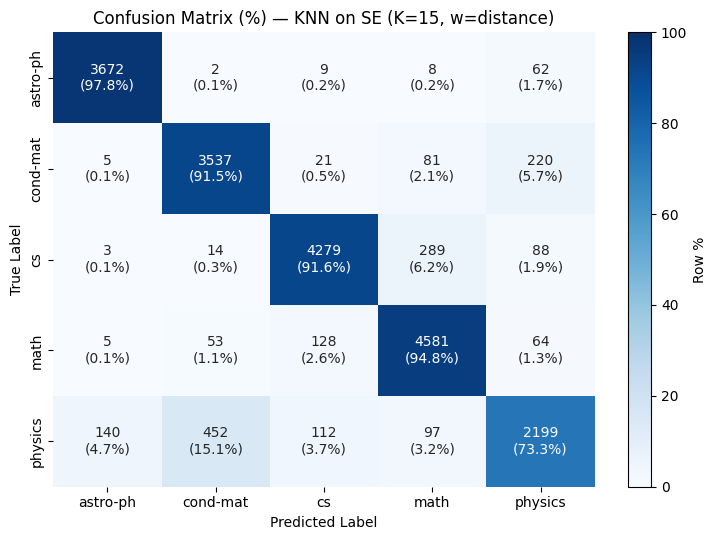

In [ ]:
# Tên lớp để hiển thị (giữ thứ tự ổn định)
CLASS_NAMES = list(label_encoder.classes_) if 'label_encoder' in globals() else sorted(pd.unique(y_test))

y_pred_test = best_knn.predict(E_test)

acc_test = accuracy_score(y_test, y_pred_test)
f1_test  = f1_score(y_test, y_pred_test, average="macro")
params   = best_knn.get_params()
print(f"\n[Test] KNN on SE — K={params['n_neighbors']}, weights={params['weights']}: "
      f"Acc={acc_test:.4f}  Macro-F1={f1_test:.4f}")

cm = confusion_matrix(y_test, y_pred_test, labels=CLASS_NAMES)
cm_pct = (cm / cm.sum(axis=1, keepdims=True) * 100)
annot = np.array([f"{int(cm[i,j])}\n({cm_pct[i,j]:.1f}%)"
                  for i in range(cm.shape[0]) for j in range(cm.shape[1])]).reshape(cm.shape)

plt.figure(figsize=(7.5, 5.5))
ax = sns.heatmap(cm_pct, annot=annot, fmt="", cmap="Blues",
                 xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
                 vmin=0, vmax=100, cbar=False)
plt.title(f"Confusion Matrix (%) — KNN on SE (K={params['n_neighbors']}, w={params['weights']})")
plt.xlabel("Predicted Label"); plt.ylabel("True Label")
plt.colorbar(ax.get_children()[0], label="Row %")
plt.tight_layout(); plt.show()

##Streamlit & Ứng dụng

In [ ]:
!pip install streamlit pyngrok -q

In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import re, time, hashlib

st.set_page_config(page_title="Định vị Chuyên ngành (Demo)", page_icon="📚", layout="wide")

st.markdown("""
<style>
@import url('https://fonts.googleapis.com/css2?family=Inter:wght@400;600;800&family=Source+Serif+Pro:wght@400;600&display=swap');
:root { --bg:#0F172A; --card:#111827; --muted:#94a3b8; --accent:#38bdf8; --accent-2:#16a34a; --danger:#ef4444; --warning:#f59e0b; --ring:rgba(56,189,248,.35); }
html, body, [class^="css"]{font-family:'Inter',system-ui,-apple-system,Segoe UI,Roboto,Arial,sans-serif;}
.block-container{padding-top:2rem;padding-bottom:3rem;}
.hero{background:radial-gradient(1200px 400px at 10% 0%,rgba(56,189,248,.15),transparent 35%),radial-gradient(900px 400px at 90% 0%,rgba(52,211,153,.12),transparent 40%);border:1px solid rgba(148,163,184,.18);box-shadow:0 10px 30px rgba(2,6,23,.35);border-radius:20px;padding:28px;margin-bottom:18px;}
.hero h1{margin:0;color:#E2E8F0;font-weight:800;letter-spacing:.2px;}
.hero p{margin-top:.25rem;color:var(--muted);}
.card{background:rgba(2,6,23,.6);backdrop-filter:blur(6px);border:1px solid rgba(148,163,184,.18);border-radius:18px;padding:18px;}
.badge{display:inline-flex;align-items:center;gap:.5rem;padding:10px 14px;border-radius:999px;font-weight:700;letter-spacing:.2px;font-size:1rem;color:#fff;background:linear-gradient(90deg,var(--accent),#22c55e);box-shadow:0 6px 22px rgba(56,189,248,.25);border:1px solid rgba(56,189,248,.35);}
.pill{display:inline-block;padding:4px 10px;border-radius:999px;font-weight:600;font-size:.82rem;border:1px solid;}
.pill.ok{color:#16a34a;border-color:#16a34a33;background:#16a34a1a;}
.pill.mid{color:#f59e0b;border-color:#f59e0b33;background:#f59e0b1a;}
.pill.low{color:#ef4444;border-color:#ef444433;background:#ef44441a;}
.note{color:var(--muted);font-size:.9rem;}
hr{border-color:rgba(148,163,184,.18);}
</style>
""", unsafe_allow_html=True)

st.markdown("""
<div class="hero">
  <h1>📚 Định vị Chuyên ngành — Academic Classifier (Demo)</h1>
  <p>Mô phỏng phân loại 5 lĩnh vực: <b>astro-ph</b>, <b>cond-mat</b>, <b>cs</b>, <b>math</b>, <b>physics</b>.
  Bản demo này <i>chỉ mô phỏng xác suất</i> để kiểm thử giao diện trước khi tích hợp KNN + SPECTER.</p>
</div>
""", unsafe_allow_html=True)

LABELS=[("astro-ph","Vật lý thiên văn"),("cond-mat","Vật chất ngưng tụ"),("cs","Khoa học máy tính"),("math","Toán học"),("physics","Vật lý")]
KEYWORDS={
 "cs":["neural","network","learning","transformer","graph","algorithm","dataset","embedding","optimization","computer","classification"],
 "math":["theorem","lemma","proof","manifold","algebra","topology","stochastic","analysis","differential","inequality","group"],
 "physics":["quantum","particle","spin","entanglement","boson","fermion","hamiltonian","relativistic","optical","lattice"],
 "cond-mat":["superconduct","magnetic","electron","phase","condensed","crystal","phonon","transport","fermi","band"],
 "astro-ph":["galaxy","cosmic","stellar","star","planetary","nebula","telescope","cosmology","dark matter","gravitational"],
}

def _softmax(x):
    x=np.asarray(x,dtype=float); x-=x.max(); e=np.exp(x); return e/e.sum()

def _seed_from_text(text:str)->int:
    if not text.strip(): return 0
    h=hashlib.blake2b(text.encode("utf-8"),digest_size=8).hexdigest()
    return int(h,16)&0xFFFFFFFF

def dummy_predict_proba(text:str)->pd.DataFrame:
    seed=_seed_from_text(text); rng=np.random.default_rng(seed)
    baseline={"astro-ph":0.0,"cond-mat":0.1,"cs":0.25,"math":0.3,"physics":0.15}
    kw_scores={k:0.0 for k,_ in LABELS}; low=text.lower()
    for label,kws in KEYWORDS.items():
        score=0.0
        for kw in kws:
            score+=0.7*len(re.findall(rf"\\b{re.escape(kw)}\\b",low))
        kw_scores[label]=score
    scores=[]
    for key,_ in LABELS:
        s=baseline[key]+0.40*kw_scores.get(key,0.0)+rng.normal(0,0.25)
        scores.append(s)
    probs=_softmax(scores)
    df=pd.DataFrame({"label":[k for k,_ in LABELS],"display":[n for _,n in LABELS],"proba":probs}).sort_values("proba",ascending=False).reset_index(drop=True)
    return df

def confidence_level(df_probs:pd.DataFrame)->str:
    if df_probs.empty: return "low"
    margin=df_probs.loc[0,"proba"]-df_probs.loc[1,"proba"]
    return "ok" if margin>=0.25 else "mid" if margin>=0.12 else "low"

with st.sidebar:
    st.markdown("### 📎 Quick Samples")
    samples={
      "CS – Graph Neural Networks":"We present a scalable graph neural network for node classification with transformer-style attention and contrastive learning on large-scale datasets.",
      "Math – Stochastic PDE":"We prove existence and uniqueness results for a class of stochastic partial differential equations on compact manifolds with boundary.",
      "Astro-ph – Exoplanet Transit":"Using space telescope photometry we detect transit signals of a new exoplanet candidate and derive stellar parameters via spectral fitting.",
      "Cond-mat – Superconductivity":"We report unconventional superconductivity near a magnetic quantum critical point with strong electron-phonon coupling and anisotropic gap.",
      "Physics – Quantum Entanglement":"We analyze multipartite quantum entanglement generation in spin-1/2 systems using a time-dependent Hamiltonian and optical lattices."
    }
    picked=st.selectbox("Chọn một ví dụ để thử:", list(samples.keys()))
    st.caption("Chọn ví dụ sẽ điền nội dung vào ô nhập liệu ở bên phải.")
    st.markdown("---")
    st.markdown("### ℹ️ Thông tin")
    st.write("Bản demo này **mô phỏng** xác suất (không dùng KNN thật). Mục tiêu là kiểm tra **trải nghiệm giao diện**.")
    st.markdown("<span class='note'>Gợi ý tích hợp thật: SPECTER ➜ FAISS/Annoy ➜ phân bố nhãn từ KNN (weights=distance).</span>", unsafe_allow_html=True)

left,right=st.columns([6,5],gap="large")
with left:
    st.markdown("#### ✍️ Nhập tóm tắt (abstract)")
    if "text" not in st.session_state: st.session_state.text=samples[picked]
    if st.session_state.get("last_sample")!=picked and st.session_state.get("text_is_user")!=True:
        st.session_state.text=samples[picked]; st.session_state.last_sample=picked
    txt=st.text_area("", value=st.session_state.text, height=280, placeholder="Dán abstract bài báo của bạn vào đây…")
    if txt!=st.session_state.text:
        st.session_state.text_is_user=True; st.session_state.text=txt
    c1,c2,_=st.columns([1,1,3])
    with c1: run=st.button("🔍 Phân loại", type="primary", use_container_width=True)
    with c2:
        if st.button("🧹 Xóa", use_container_width=True):
            st.session_state.text=""; st.session_state.text_is_user=True; st.rerun()
    st.markdown("<div id='result-anchor'></div>", unsafe_allow_html=True)

with right:
    st.markdown("#### 📊 Kết quả & Biểu đồ")
    result_card=st.container()
    chart_area=st.container()

if 'run_once' not in st.session_state: st.session_state.run_once=False
if run:
    if not st.session_state.text.strip():
        st.warning("Vui lòng nhập abstract trước khi phân loại.")
    else:
        with st.spinner("Đang phân tích & tính toán xác suất…"):
            prog=st.progress(0)
            for i in range(35):
                time.sleep(0.01); prog.progress(int((i+1)/35*100))
            df=dummy_predict_proba(st.session_state.text); prog.empty()
        top_label=df.loc[0,"label"]; top_name=df.loc[0,"display"]; conf=confidence_level(df)
        result_card.markdown(f"""
        <div class="card">
          <div style="display:flex;align-items:center;justify-content:space-between;gap:10px;flex-wrap:wrap;">
            <div class="badge">Kết quả: <span style="font-weight:800">{top_label}</span> — {top_name}</div>
            <div><span class="pill {'ok' if conf=='ok' else 'mid' if conf=='mid' else 'low'}">
              Độ tự tin: {"Cao" if conf=="ok" else "Trung bình" if conf=="mid" else "Thấp"}
            </span></div>
          </div>
          <div style="margin-top:.6rem" class="note">*Lưu ý: các giá trị xác suất bên dưới là mô phỏng.</div>
        </div>
        """, unsafe_allow_html=True)
        df_chart=df.copy(); df_chart["class"]=df_chart["label"]+" – "+df_chart["display"]
        df_chart=df_chart[["class","proba"]].set_index("class")
        with chart_area:
            st.bar_chart(df_chart, height=290, use_container_width=True)
            df_pct=df.copy(); df_pct["prob (%)"]=(100*df_pct["proba"]).round(2)
            st.dataframe(df_pct[["label","display","prob (%)"]], use_container_width=True, hide_index=True)
        st.markdown("""
        <script>
        const anchor=window.parent.document.querySelector('#result-anchor');
        if(anchor){anchor.scrollIntoView({behavior:'smooth',block:'start'});}
        </script>
        """, unsafe_allow_html=True)

with st.expander("🔧 Hướng dẫn tích hợp KNN + SPECTER (sau khi duyệt UI)"):
    st.markdown("""
- Encode: `SentenceTransformer('sentence-transformers/allenai-specter')`, normalize L2.
- Truy vấn FAISS/Annoy top-K, tính phân bố nhãn theo trọng số khoảng cách.
- Trả về xác suất cho 5 lớp để vẽ biểu đồ như demo.
""")
st.markdown("<hr/>", unsafe_allow_html=True)
st.caption("© Demo UI cho bộ phân loại 5 chuyên ngành — Streamlit • Thiết kế: tối giản, học thuật, hiện đại.")


Writing app.py


In [ ]:
# Cell cuối cùng (đã sửa lỗi)
# Chạy cell này thay cho cell cũ của bạn

!nohup streamlit run app.py &

from pyngrok import ngrok
from google.colab import userdata # Thư viện để đọc secrets
import time

# Lấy authtoken từ Colab Secrets và xác thực với ngrok
try:
  NGROK_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
  ngrok.set_auth_token(NGROK_TOKEN)
except userdata.SecretNotFoundError:
  print("LỖI: Secret 'NGROK_AUTH_TOKEN' chưa được tạo.")
  print("Vui lòng làm theo hướng dẫn ở Bước 2 để thêm Authtoken.")
  raise SystemExit # Dừng thực thi nếu không có token

# Chờ một chút để server streamlit khởi động
time.sleep(5)

# Tạo tunnel đến port 8501 (port mặc định của streamlit)
try:
  public_url = ngrok.connect(8501)
  print("✅ Ứng dụng của bạn đã sẵn sàng! Click vào đường link sau:")
  print(public_url)
except Exception as e:
  print(f"Lỗi khi tạo tunnel ngrok: {e}")
  print("Hãy thử chạy lại cell này.")

nohup: appending output to 'nohup.out'
✅ Ứng dụng của bạn đã sẵn sàng! Click vào đường link sau:
NgrokTunnel: "https://03f7747fb2aa.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!ps -ef | grep streamlit

root       35747    2131  0 06:47 ?        00:00:00 /bin/bash -c ps -ef | grep streamlit
root       35749   35747  0 06:47 ?        00:00:00 grep streamlit


In [ ]:
!kill 31145 32014 32725